In [1]:
library(ggplot2)
library(tidyverse)
library(MASS)
library(janitor)
library(dplyr)
library(pROC)
library(irr)
library(reshape2)
library(caret)

# Useful function
# Cross validation LDA
# Cross validation LDA
lda_cross_validate <- function(model_formula, data, k = 5) {
    set.seed(123) # Set seed for reproducibility
    
    # Create k-folds
    folds <- sample(rep(1:k, length.out = nrow(data)))
    
    # Initialize a list to store results and models
    results <- list()
    models <- list()
    
    # Perform cross-validation
    for (i in 1:k) {
        # Split data into training and testing sets
        train_data <- data[folds != i, ]
        test_data <- data[folds == i, ]
        
        # Train the model on the training set
        model <- lda(formula = model_formula, data = train_data)
        
        # Predict on the testing set
        predictions <- predict(model, test_data)$class
        
        # Calculate metrics
        confusion <- table(predictions, test_data$diabetes_012)
        accuracy <- sum(diag(confusion)) / sum(confusion)
        precision <- diag(confusion) / rowSums(confusion)
        precision[is.nan(precision)] <- 0
        recall <- diag(confusion) / colSums(confusion)
        recall[is.nan(recall)] <- 0
        f1 <- 2 * (precision * recall) / (precision + recall)
        f1[is.nan(f1)] <- 0
        
        # Convert confusion matrix to data frame for kappam.fleiss
        confusion_df <- as.data.frame(as.table(confusion))
        kappa <- kappam.fleiss(confusion_df)$value
        
        # Store the result and model
        results[[i]] <- list(
            accuracy = accuracy,
            precision = precision,
            recall = recall,
            f1 = f1,
            kappa = kappa
        )
        models[[i]] <- model
    }
    
    return(list(models = models, results = results))
}

# Cross validation QDA
qda_cross_validate <- function(model_formula, data, k = 5) {
    set.seed(123) # Set seed for reproducibility
    
    # Create k-folds
    folds <- sample(rep(1:k, length.out = nrow(data)))
    
    # Initialize a list to store results and models
    results <- list()
    models <- list()
    
    # Perform cross-validation
    for (i in 1:k) {
        # Split data into training and testing sets
        train_data <- data[folds != i, ]
        test_data <- data[folds == i, ]
        
        # Train the model on the training set
        model <- qda(formula = model_formula, data = train_data)
        
        # Predict on the testing set
        predictions <- predict(model, test_data)$class
        
        # Calculate metrics
        confusion <- table(predictions, test_data$diabetes_012)
        accuracy <- sum(diag(confusion)) / sum(confusion)
        precision <- diag(confusion) / rowSums(confusion)
        precision[is.nan(precision)] <- 0
        recall <- diag(confusion) / colSums(confusion)
        recall[is.nan(recall)] <- 0
        f1 <- 2 * (precision * recall) / (precision + recall)
        f1[is.nan(f1)] <- 0
        
        # Convert confusion matrix to data frame for kappam.fleiss
        confusion_df <- as.data.frame(as.table(confusion))
        kappa <- kappam.fleiss(confusion_df)$value
        
        # Store the result and model
        results[[i]] <- list(
            accuracy = accuracy,
            precision = precision,
            recall = recall,
            f1 = f1,
            kappa = kappa
        )
        models[[i]] <- model
    }
    
    return(list(models = models, results = results))
}

eval_multi_class <- function(x) {
    cc <- sum(diag(x))
    sc <- sum(x)
    pp <- colSums(x)
    tt <- rowSums(x)
    ##
    prec <- diag(x)/colSums(x)
    recall <- diag(x)/rowSums(x)
    macro_prec <- mean(prec)
    macro_recall <- mean(recall)
    macro_f1 <- 2 * macro_prec * macro_recall/(1/macro_prec + 1/macro_recall)
    acc <- cc/sc
    kap <- (cc * sc - sum(pp * tt))/(sc^2 - sum(pp * tt))
    return(list(Precision = prec, Recall = recall, Accuracy = acc, Kappa = kap,
        Macro_F1 = macro_f1))
}

evaluate_models <- function(train_data, test_data) {
    # Apply cross-validation on train_data for LDA
    lda_results <- lda_cross_validate(diabetes_012 ~ ., train_data)
    lda_avg_results <- sapply(lda_results$results, function(res) sapply(res, mean))

    # Apply cross-validation on train_data for QDA
    qda_results <- qda_cross_validate(diabetes_012 ~ ., train_data)
    qda_avg_results <- sapply(qda_results$results, function(res) sapply(res, mean))

    # Combine results into a data frame
    avg_results <- data.frame(
        Metric = c("Accuracy", "Precision", "Recall", "F1", "Kappa"),
        LDA = lda_avg_results,
        QDA = qda_avg_results
    )

    # Print the results as a table
    print(avg_results)

    # Cross-validation on train_data for LDA
    lda_results <- lda_cross_validate(diabetes_012 ~ ., train_data)
    lda_avg_results <- sapply(lda_results$results, function(res) sapply(res, mean))
    
    # Cross-validation on train_data for QDA
    qda_results <- qda_cross_validate(diabetes_012 ~ ., train_data)
    qda_avg_results <- sapply(qda_results$results, function(res) sapply(res, mean))
    
    # Determine the best model based on average F1 score
    best_model <- ifelse(mean(lda_avg_results["f1", ]) > mean(qda_avg_results["f1", ]), "LDA", "QDA")
    
    # Train the best LDA model on the entire training data
    final_lda_model <- lda(diabetes_012 ~ ., data = train_data)
    
    # Train the best QDA model on the entire training data
    final_qda_model <- qda(diabetes_012 ~ ., data = train_data)
    
    # Predict on the test data using both models
    lda_predictions <- predict(final_lda_model, test_data)$class
    qda_predictions <- predict(final_qda_model, test_data)$class
    
    # Get predicted probabilities for both models
    lda_pred_probs <- predict(final_lda_model, test_data)$posterior
    qda_pred_probs <- predict(final_qda_model, test_data)$posterior
    
    # Create confusion matrices for both models
    lda_confusion <- table(test_data$diabetes_012, lda_predictions)
    qda_confusion <- table(test_data$diabetes_012, qda_predictions)
    
    # Calculate metrics for LDA using eval_multi_class
    lda_metrics <- eval_multi_class(lda_confusion)
    
    # Calculate metrics for QDA using eval_multi_class
    qda_metrics <- eval_multi_class(qda_confusion)
    
    # Create a data frame with the results
    results <- data.frame(
        Metric = c("Accuracy", "Precision", "Recall", "F1", "Kappa"),
        LDA = c(lda_metrics$Accuracy, mean(lda_metrics$Precision, na.rm = TRUE), mean(lda_metrics$Recall, na.rm = TRUE), lda_metrics$Macro_F1, lda_metrics$Kappa),
        QDA = c(qda_metrics$Accuracy, mean(qda_metrics$Precision, na.rm = TRUE), mean(qda_metrics$Recall, na.rm = TRUE), qda_metrics$Macro_F1, qda_metrics$Kappa)
    )
    
    # Plot the metrics
    metrics_data <- melt(results, id.vars = "Metric")
    
    ggplot(metrics_data, aes(x = Metric, y = value, fill = variable)) +
        geom_bar(stat = "identity", position = "dodge") +
        labs(title = "Performance Metrics for LDA and QDA Models",
             x = "Metric",
             y = "Value") +
        theme_minimal()
    
    # Return results, predicted probabilities, and predictions
    return(list(results = results, lda_pred_probs = lda_pred_probs, qda_pred_probs = qda_pred_probs, lda_predictions = lda_predictions, qda_predictions = qda_predictions))
}

plot_confusion_matrix <- function(conf_matrix, model_name) {
    conf_matrix_df <- as.data.frame(conf_matrix)
    colnames(conf_matrix_df) <- c("Actual", "Predicted", "Freq")
    
    ggplot(conf_matrix_df, aes(x = Actual, y = Predicted, fill = Freq)) +
        geom_tile() +
        geom_text(aes(label = Freq), color = "white") +
        scale_fill_gradient(low = "lightblue", high = "lightcoral") +
        labs(title = paste("Confusion Matrix -", model_name, "Predictions"), x = "Actual", y = "Predicted") +
        theme_minimal()
}

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.0
v lubridate 1.9.3     v tibble    3.2.1
v purrr     1.0.2     v tidyr     1.3.1
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select



Attaching package: 'janitor'


The following objects are masked from 'package:stats':

    chisq.test, fisher.test


Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var


Loading required package: lpSolve


Attaching package: 'reshape2'


The following object is masked from 'package:tidyr':

    smiths


L

In [4]:
train_data = read.csv("../data/train_data.csv")
test_data = read.csv("../data/test_data.csv")

In [36]:
glimpse(train_data)

Rows: 202,944
Columns: 21
$ diabetes_012           <int> 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2,~
$ high_bp                <int> 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,~
$ high_chol              <int> 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,~
$ chol_check             <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,~
$ smoker                 <int> 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,~
$ stroke                 <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,~
$ heart_diseaseor_attack <int> 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,~
$ phys_activity          <int> 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,~
$ fruits                 <int> 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,~
$ veggies                <int> 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,~
$ hvy_alcohol_consump    <int> 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,~
$ any_healthcare         <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,~
$ no_docbc_cos

## Data Preprocessing

In [5]:
train_data <- train_data |> mutate(across(everything(), as.factor))
test_data <- test_data |> mutate(across(everything(), as.factor))

In [38]:
glimpse(train_data)

Rows: 202,944
Columns: 21
$ diabetes_012           <fct> 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2,~
$ high_bp                <fct> 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,~
$ high_chol              <fct> 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,~
$ chol_check             <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,~
$ smoker                 <fct> 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,~
$ stroke                 <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,~
$ heart_diseaseor_attack <fct> 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,~
$ phys_activity          <fct> 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,~
$ fruits                 <fct> 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,~
$ veggies                <fct> 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,~
$ hvy_alcohol_consump    <fct> 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,~
$ any_healthcare         <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,~
$ no_docbc_cos

In [39]:
print(table(train_data$diabetes_012))
print(table(test_data$diabetes_012))


     0      1      2 
170989   3676  28279 

    0     1     2 
42714   955  7067 


## Modeling

Hàm Cross Validation với K Folds = 5 cho LDA và QDA

### Thử trên data gốc

In [79]:
results = evaluate_models(train_data, test_data)

             Metric       LDA.1       LDA.2       LDA.3       LDA.4       LDA.5
accuracy   Accuracy  0.84495799  0.84712607  0.84303629  0.84633768  0.84446142
precision Precision  0.45549125  0.46067685  0.45302742  0.46273847  0.45650112
recall       Recall  0.40552203  0.40507449  0.40300278  0.40781005  0.40665185
f1               F1  0.41731344  0.41760862  0.41426471  0.42060166  0.41849043
kappa         Kappa -0.06930693 -0.06930693 -0.06930693 -0.06930693 -0.06930693
                QDA.1       QDA.2       QDA.3       QDA.4       QDA.5
accuracy   0.66444110  0.66441647  0.66461357  0.67143807  0.66867054
precision  0.41995178  0.41738759  0.42015019  0.41827839  0.42157469
recall     0.49421047  0.49036649  0.49323493  0.49208998  0.49568756
f1         0.40806339  0.40724510  0.40860701  0.40768004  0.41112870
kappa     -0.05882353 -0.05882353 -0.05882353 -0.05882353 -0.05882353


Warning message in cc * sc:
"NAs produced by integer overflow"


   
        0     1     2
  0 41160     0  1554
  1   828     0   127
  2  5278     0  1789

Warning message in cc * sc:
"NAs produced by integer overflow"


$Precision
        0         1         2 
0.8708162       NaN 0.5155620 

$Recall
        0         1         2 
0.9636185 0.0000000 0.2531484 

$Accuracy
[1] 0.8465192

$Kappa
[1] NA

$Macro_F1
[1] NaN

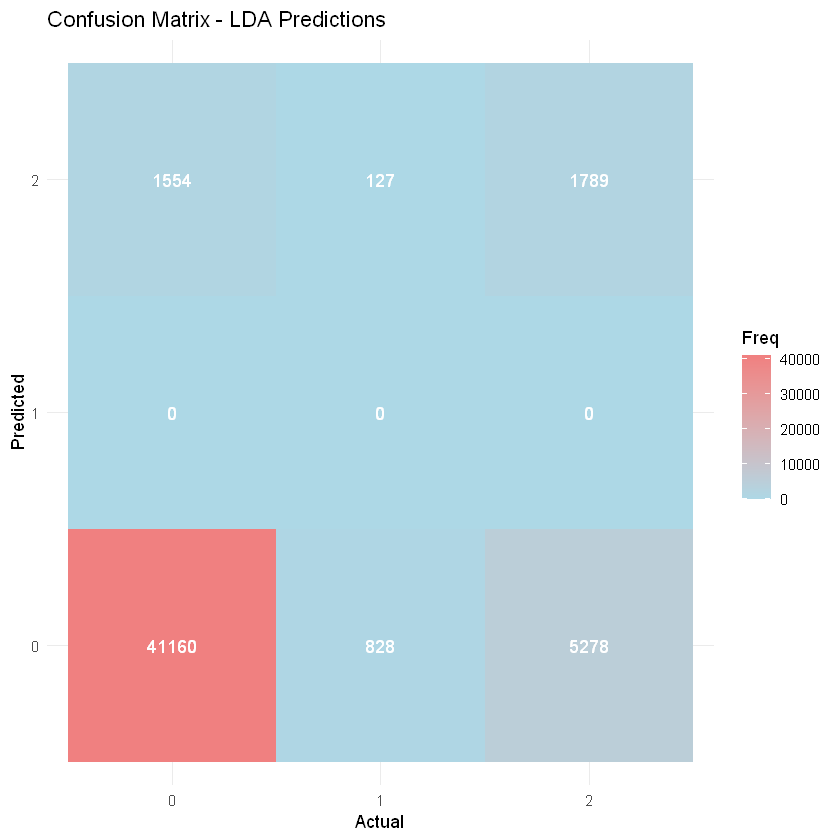

In [81]:
conf_matrix <- table(test_data$diabetes_012, results$lda_predictions)
conf_matrix

eval_multi_class(conf_matrix)

plot_confusion_matrix(conf_matrix, "LDA")

   
        0     1     2
  0 28225   760 13729
  1   322    26   607
  2  1418   164  5485

$Precision
         0          1          2 
0.94193225 0.02736842 0.27672670 

$Recall
         0          1          2 
0.66079037 0.02722513 0.77614263 

$Accuracy
[1] 0.6649322

$Kappa
[1] 0.2520931

$Macro_F1
[1] 0.09097003

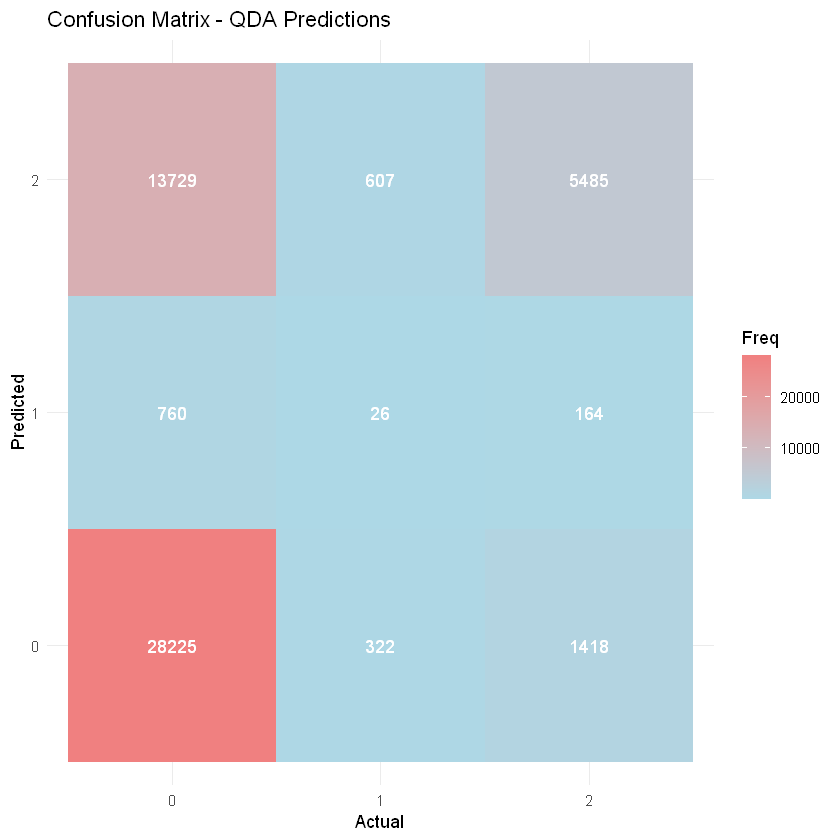

In [82]:
conf_matrix <- table(test_data$diabetes_012, results$qda_predictions)
conf_matrix

eval_multi_class(conf_matrix)
plot_confusion_matrix(conf_matrix, "QDA")

### Thử trên Data Oversampling

In [9]:
oversampling_data <- read.csv("../data/oversampled_data.csv")
oversampling_data <- oversampling_data |> mutate(across(everything(), as.factor))

glimpse(oversampling_data)

Rows: 444,571
Columns: 21
$ diabetes_012           <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,~
$ high_bp                <fct> 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,~
$ high_chol              <fct> 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,~
$ chol_check             <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,~
$ smoker                 <fct> 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,~
$ stroke                 <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,~
$ heart_diseaseor_attack <fct> 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,~
$ phys_activity          <fct> 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,~
$ fruits                 <fct> 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,~
$ veggies                <fct> 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,~
$ hvy_alcohol_consump    <fct> 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,~
$ any_healthcare         <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,~
$ no_docbc_cos

In [48]:
table(oversampling_data$diabetes_012)


     0      1      2 
170989 136791 136791 

#### Train với thông số cơ bản

In [83]:
oversampling_results <- evaluate_models(oversampling_data, test_data)

             Metric       LDA.1       LDA.2       LDA.3       LDA.4       LDA.5
accuracy   Accuracy  0.53327335  0.53591111  0.53384169  0.53306566  0.53167105
precision Precision  0.51347902  0.51544370  0.51391501  0.51282463  0.51228970
recall       Recall  0.51937862  0.52177898  0.52027092  0.51940998  0.51875936
f1               F1  0.51358813  0.51575176  0.51439710  0.51322307  0.51278912
kappa         Kappa -0.05882353 -0.05882353 -0.05882353 -0.05882353 -0.05882353
                QDA.1       QDA.2       QDA.3       QDA.4       QDA.5
accuracy   0.51117359  0.50835639  0.51120184  0.51035832  0.50818769
precision  0.51922641  0.51505419  0.51983123  0.51713869  0.51665277
recall     0.50445183  0.50230637  0.50549365  0.50442332  0.50223266
f1         0.46259383  0.46095814  0.46502782  0.46337070  0.45969056
kappa     -0.05882353 -0.05882353 -0.05882353 -0.05882353 -0.05882353


   
        0     1     2
  0 29819  6663  6232
  1   330   293   332
  2  1446  1879  3742

$Precision
         0          1          2 
0.94378857 0.03316355 0.36308946 

$Recall
        0         1         2 
0.6981083 0.3068063 0.5295033 

$Accuracy
[1] 0.667258

$Kappa
[1] 0.2508458

$Macro_F1
[1] 0.1089517

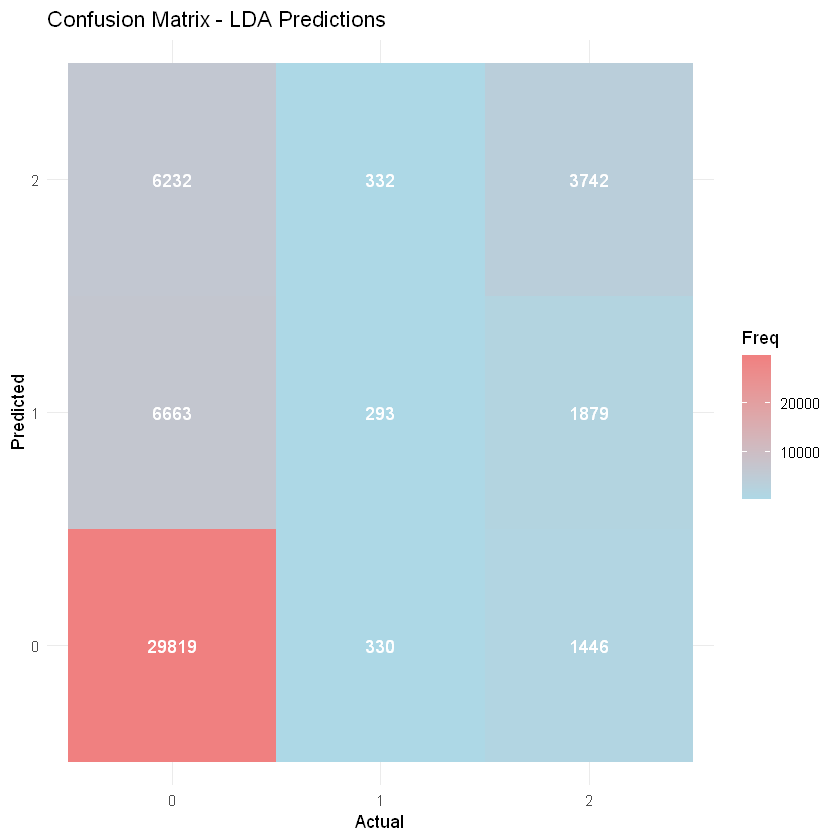

In [84]:
conf_matrix <- table(test_data$diabetes_012, oversampling_results$lda_predictions)
conf_matrix

eval_multi_class(conf_matrix)

# Plot confusion matrix using the function
plot_confusion_matrix(conf_matrix, "LDA")

   
        0     1     2
  0 24872  2986 14856
  1   228   105   622
  2   934   538  5595

$Precision
         0          1          2 
0.95536606 0.02893359 0.26550562 

$Recall
        0         1         2 
0.5822915 0.1099476 0.7917079 

$Accuracy
[1] 0.6025702

$Kappa
[1] 0.218896

$Macro_F1
[1] 0.09320272

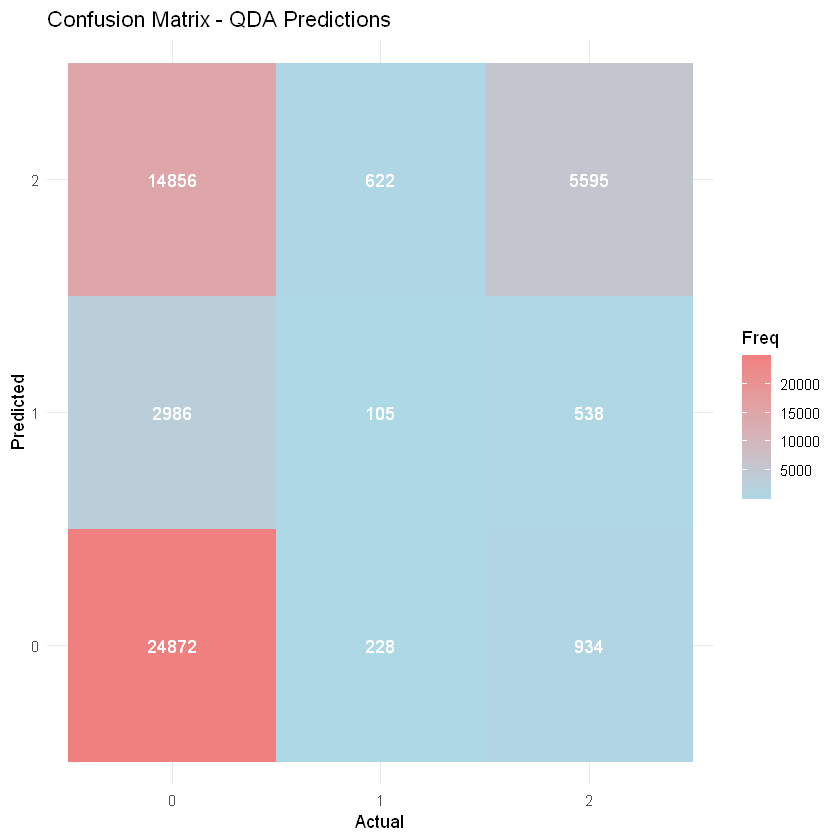

In [85]:
conf_matrix <- table(test_data$diabetes_012, oversampling_results$qda_predictions)
conf_matrix

eval_multi_class(conf_matrix)
# Plot confusion matrix using the function
plot_confusion_matrix(conf_matrix, "QDA")

#### Tăng Recall cho class 1 và class 2

In [10]:
calculate_optimal_thresholds <- function(probs, test_data) {
    # Tính PR Curve cho từng lớp (One-vs-Rest)
    pr_class0 <- pr.curve(scores.class0 = probs[, 1], weights.class0 = (test_data$diabetes_012 == 0), curve = TRUE)
    pr_class1 <- pr.curve(scores.class0 = probs[, 2], weights.class0 = (test_data$diabetes_012 == 1), curve = TRUE)
    pr_class2 <- pr.curve(scores.class0 = probs[, 3], weights.class0 = (test_data$diabetes_012 == 2), curve = TRUE)

    # Vẽ đồ thị Precision-Recall
    plot(pr_class0, col = "blue", main = "PR Curve - Class 0")
    plot(pr_class1, col = "red", add = TRUE)
    plot(pr_class2, col = "green", add = TRUE)
    legend("bottomleft", legend = c("Class 0", "Class 1", "Class 2"), col = c("blue", "red", "green"), lty = 1)

    # Tính F1-Score cho từng lớp
    precision0 <- pr_class0$curve[, 1]
    recall0 <- pr_class0$curve[, 2]
    f1_class0 <- 2 * (precision0 * recall0) / (precision0 + recall0)
    optimal_threshold0 <- pr_class0$curve[which.max(f1_class0), 3]

    precision1 <- pr_class1$curve[, 1]
    recall1 <- pr_class1$curve[, 2]
    f1_class1 <- 2 * (precision1 * recall1) / (precision1 + recall1)
    optimal_threshold1 <- pr_class1$curve[which.max(f1_class1), 3]

    precision2 <- pr_class2$curve[, 1]
    recall2 <- pr_class2$curve[, 2]
    f1_class2 <- 2 * (precision2 * recall2) / (precision2 + recall2)
    optimal_threshold2 <- pr_class2$curve[which.max(f1_class2), 3]

    # In ngưỡng tối ưu
    optimal_threshold0
    optimal_threshold1
    optimal_threshold2

    # Đặt ngưỡng tối ưu
    thresholds <- c(optimal_threshold0, optimal_threshold1, optimal_threshold2)

    # Điều chỉnh xác suất dự đoán
    adjusted_probs <- probs
    adjusted_probs[, 1] <- ifelse(probs[, 1] > thresholds[1], probs[, 1], 0)
    adjusted_probs[, 2] <- ifelse(probs[, 2] > thresholds[2], probs[, 2], 0)
    adjusted_probs[, 3] <- ifelse(probs[, 3] > thresholds[3], probs[, 3], 0)

    # Phân loại dựa trên xác suất cao nhất
    predicted_class <- apply(adjusted_probs, 1, which.max) - 1

    return(list(optimal_thresholds = thresholds, predicted_class = predicted_class))
}

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

In [87]:
lda_probs <- probs$lda_pred_probs
qda_probs <- probs$qda_pred_probs

Cho LDA

   predicted_class
        0     1     2
  0 34396  1451  6867
  1   477   106   372
  2  2432   562  4073

$Precision
        0         1         2 
0.9220212 0.0500236 0.3600601 

$Recall
        0         1         2 
0.8052629 0.1109948 0.5763407 

$Accuracy
[1] 0.7603083

$Kappa
[1] 0.3134754

$Macro_F1
[1] 0.1036707

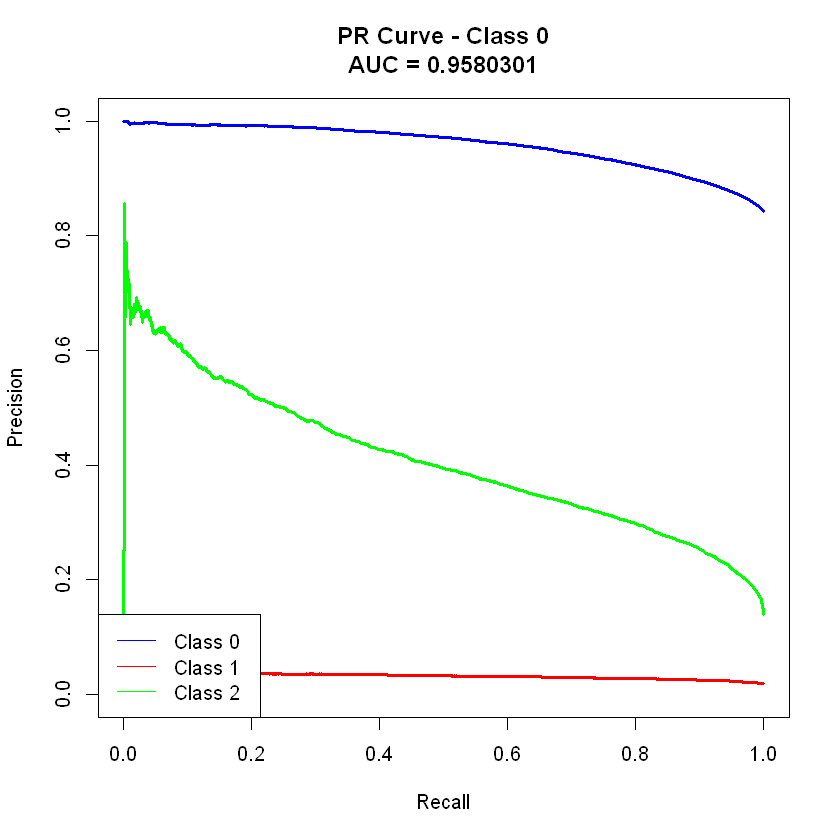

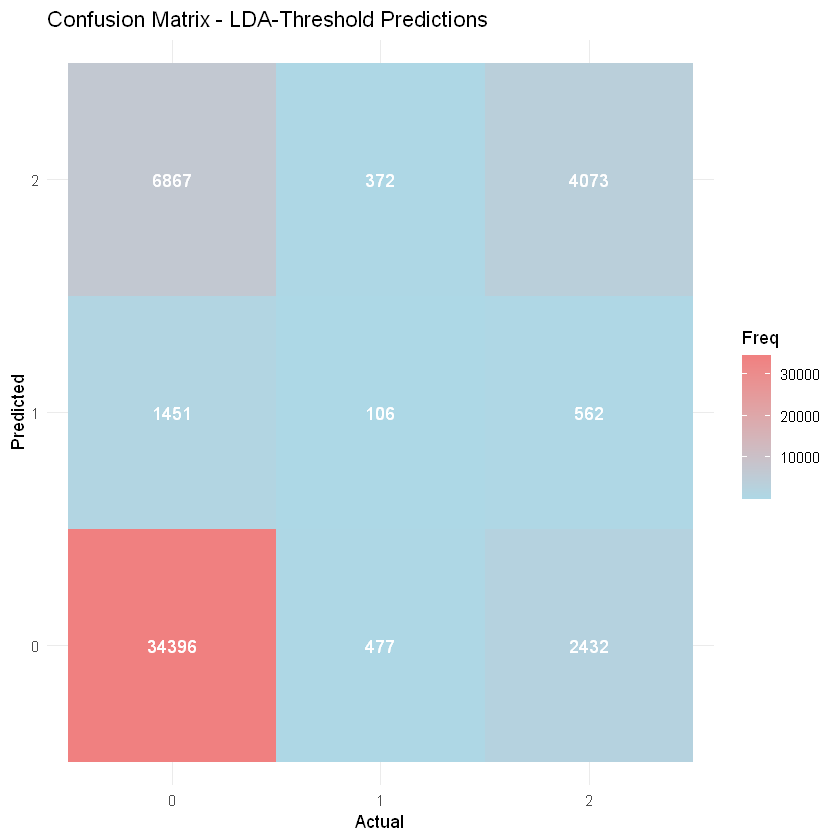

In [88]:
result <- calculate_optimal_thresholds(lda_probs, test_data)
predicted_class <- result$predicted_class
optimal_thresholds <- result$optimal_thresholds

conf_matrix <- table(test_data$diabetes_012, predicted_class)
conf_matrix

eval_multi_class(conf_matrix)
# Plot confusion matrix using the function
plot_confusion_matrix(conf_matrix, "LDA-Threshold")

Cho QDA

   predicted_class
        0     1     2
  0 26870  6862  8982
  1   282   244   429
  2  1272  1337  4458

$Precision
         0          1          2 
0.94532789 0.02889968 0.32143630 

$Recall
        0         1         2 
0.6290678 0.2554974 0.6308193 

$Accuracy
[1] 0.62228

$Kappa
[1] 0.2246149

$Macro_F1
[1] 0.1015847

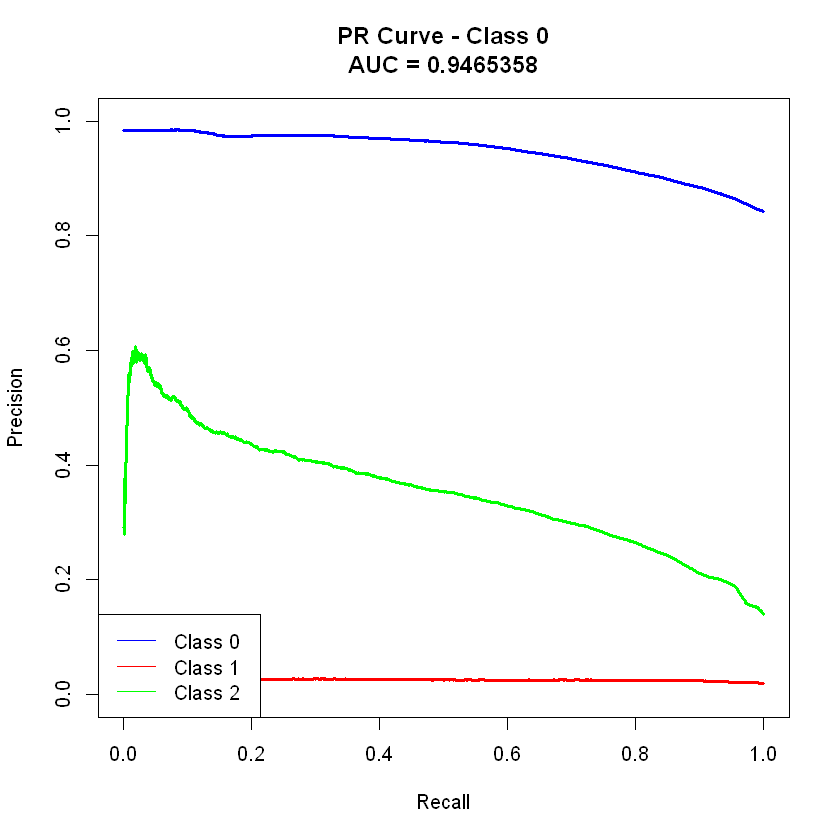

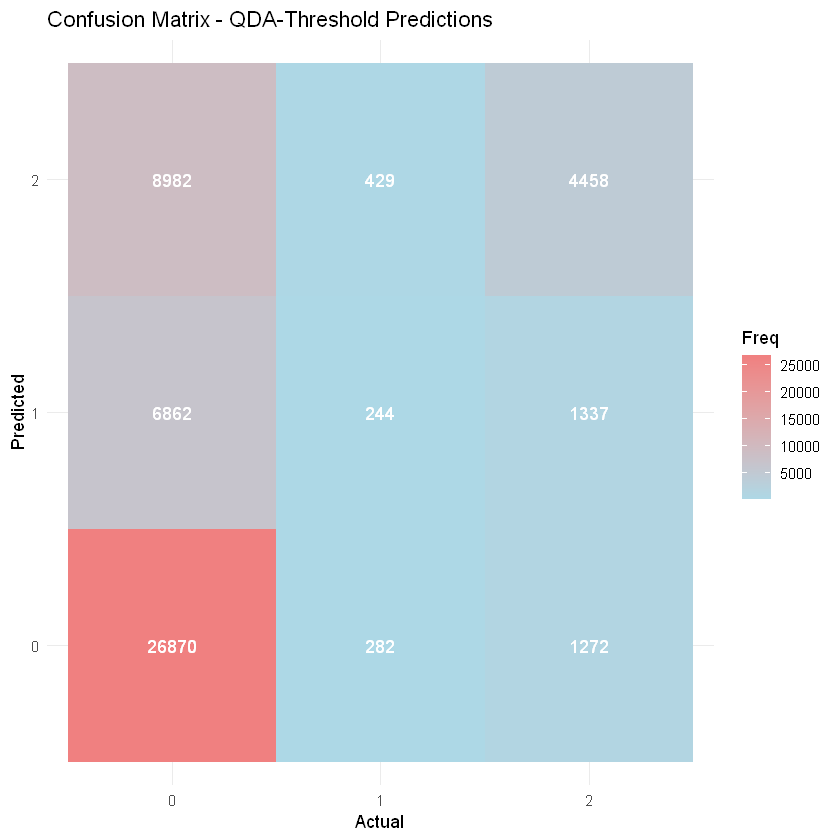

In [89]:
result <- calculate_optimal_thresholds(qda_probs, test_data)
predicted_class <- result$predicted_class
optimal_thresholds <- result$optimal_thresholds

conf_matrix <- table(test_data$diabetes_012, predicted_class)
conf_matrix

eval_multi_class(conf_matrix)
# Plot confusion matrix using the function
plot_confusion_matrix(conf_matrix, "QDA-Threshold")

### Thử trên Data Undersampling

In [6]:
undersampling_data <- read.csv("../data/undersampled_data.csv")
undersampling_data <- undersampling_data |> mutate(across(everything(), as.factor))

glimpse(undersampling_data)

table(undersampling_data$diabetes_012)

Rows: 11,028
Columns: 21
$ diabetes_012           <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,~
$ high_bp                <fct> 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,~
$ high_chol              <fct> 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,~
$ chol_check             <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,~
$ smoker                 <fct> 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,~
$ stroke                 <fct> 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,~
$ heart_diseaseor_attack <fct> 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,~
$ phys_activity          <fct> 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,~
$ fruits                 <fct> 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,~
$ veggies                <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,~
$ hvy_alcohol_consump    <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,~
$ any_healthcare         <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,~
$ no_docbc_cost


   0    1    2 
3676 3676 3676 

#### Train với thông số cơ bản

In [7]:
# Train LDA model on undersampling_data
lda_model <- lda(diabetes_012 ~ ., data = undersampling_data)

# Predict on undersampling_data
lda_predictions_train <- predict(lda_model, undersampling_data)$class
lda_pred_probs_train <- predict(lda_model, undersampling_data)$posterior

# Calculate confusion matrix and metrics for training data
lda_conf_matrix_train <- table(undersampling_data$diabetes_012, lda_predictions_train)
lda_metrics_train <- eval_multi_class(lda_conf_matrix_train)

# Print metrics for training data
cat("LDA Training Metrics:\n")
print(lda_metrics_train)

# Predict on test_data
lda_predictions <- predict(lda_model, test_data)$class
lda_pred_probs <- predict(lda_model, test_data)$posterior

# Train QDA model on undersampling_data
qda_model <- qda(diabetes_012 ~ ., data = undersampling_data)

# Predict on undersampling_data
qda_predictions_train <- predict(qda_model, undersampling_data)$class
qda_pred_probs_train <- predict(qda_model, undersampling_data)$posterior

# Calculate confusion matrix and metrics for training data
qda_conf_matrix_train <- table(undersampling_data$diabetes_012, qda_predictions_train)
qda_metrics_train <- eval_multi_class(qda_conf_matrix_train)

# Print metrics for training data
cat("QDA Training Metrics:\n")
print(qda_metrics_train)

# Predict on test_data
qda_predictions <- predict(qda_model, test_data)$class
qda_pred_probs <- predict(qda_model, test_data)$posterior

# Return predictions and probabilities for both models
undersampling_results <- list(
    lda_predictions = lda_predictions,
    lda_pred_probs = lda_pred_probs,
    qda_predictions = qda_predictions,
    qda_pred_probs = qda_pred_probs
)
train_and_evaluate_models <- function(train_data, test_data) {
    # Train LDA model on train_data
    lda_model <- lda(diabetes_012 ~ ., data = train_data)
    
    # Predict on train_data
    lda_predictions_train <- predict(lda_model, train_data)$class
    lda_pred_probs_train <- predict(lda_model, train_data)$posterior
    
    # Calculate confusion matrix and metrics for training data
    lda_conf_matrix_train <- table(train_data$diabetes_012, lda_predictions_train)
    lda_metrics_train <- eval_multi_class(lda_conf_matrix_train)
    
    # Print metrics for training data
    cat("LDA Training Metrics:\n")
    print(lda_metrics_train)
    
    # Predict on test_data
    lda_predictions <- predict(lda_model, test_data)$class
    lda_pred_probs <- predict(lda_model, test_data)$posterior
    
    # Train QDA model on train_data
    qda_model <- qda(diabetes_012 ~ ., data = train_data)
    
    # Predict on train_data
    qda_predictions_train <- predict(qda_model, train_data)$class
    qda_pred_probs_train <- predict(qda_model, train_data)$posterior
    
    # Calculate confusion matrix and metrics for training data
    qda_conf_matrix_train <- table(train_data$diabetes_012, qda_predictions_train)
    qda_metrics_train <- eval_multi_class(qda_conf_matrix_train)
    
    # Print metrics for training data
    cat("QDA Training Metrics:\n")
    print(qda_metrics_train)
    
    # Predict on test_data
    qda_predictions <- predict(qda_model, test_data)$class
    qda_pred_probs <- predict(qda_model, test_data)$posterior
    
    # Return predictions and probabilities for both models
    return(list(
        lda_predictions = lda_predictions,
        lda_pred_probs = lda_pred_probs,
        qda_predictions = qda_predictions,
        qda_pred_probs = qda_pred_probs
    ))
}

LDA Training Metrics:
$Precision
        0         1         2 
0.6191983 0.4317751 0.5103194 

$Recall
        0         1         2 
0.6387378 0.3718716 0.5650163 

$Accuracy
[1] 0.5252086

$Kappa
[1] 0.2878128

$Macro_F1
[1] 0.1429018

QDA Training Metrics:
$Precision
        0         1         2 
0.6395955 0.5007485 0.4521699 

$Recall
        0         1         2 
0.5677367 0.1819913 0.7908052 

$Accuracy
[1] 0.5135111

$Kappa
[1] 0.2702666

$Macro_F1
[1] 0.142301



Cho LDA

   
        0     1     2
  0 26875  8942  6897
  1   261   345   349
  2  1024  2149  3894

$Precision
         0          1          2 
0.95436790 0.03016789 0.34955117 

$Recall
        0         1         2 
0.6291848 0.3612565 0.5510117 

$Accuracy
[1] 0.6132529

$Kappa
[1] 0.223245

$Macro_F1
[1] 0.1089371

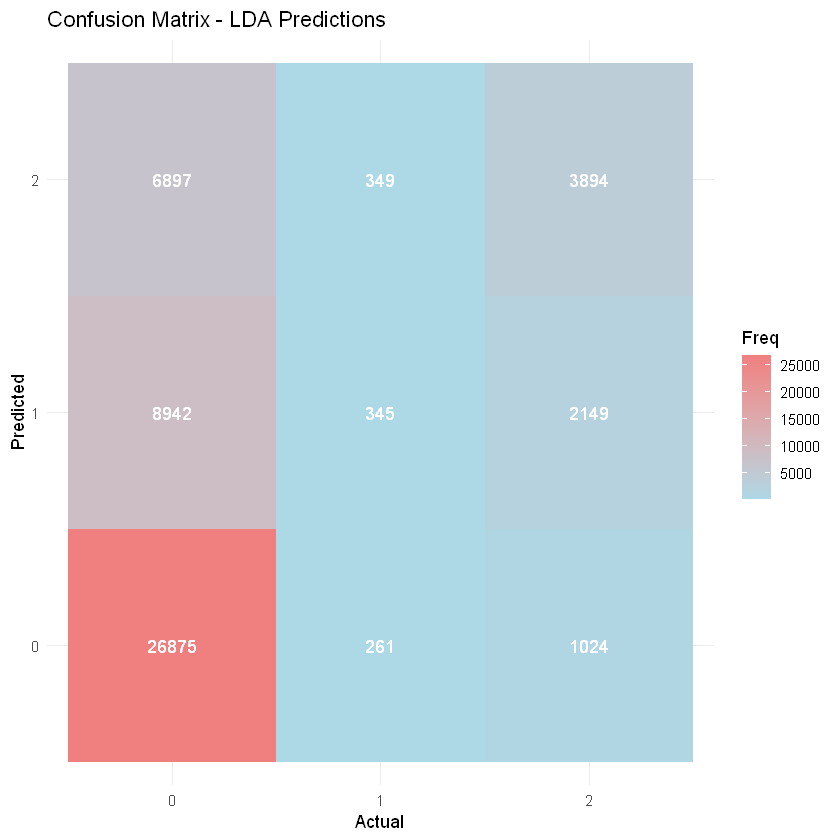

In [105]:
conf_matrix <- table(test_data$diabetes_012, undersampling_results$lda_predictions)
conf_matrix

eval_multi_class(conf_matrix)

# Plot confusion matrix using the function
plot_confusion_matrix(conf_matrix, "LDA")

Cho QDA

   
        0     1     2
  0 23879  4223 14612
  1   208   133   614
  2   846   740  5481

$Precision
        0         1         2 
0.9577267 0.0260989 0.2646931 

$Recall
        0         1         2 
0.5590439 0.1392670 0.7755766 

$Accuracy
[1] 0.5813032

$Kappa
[1] 0.2063151

$Macro_F1
[1] 0.09213658

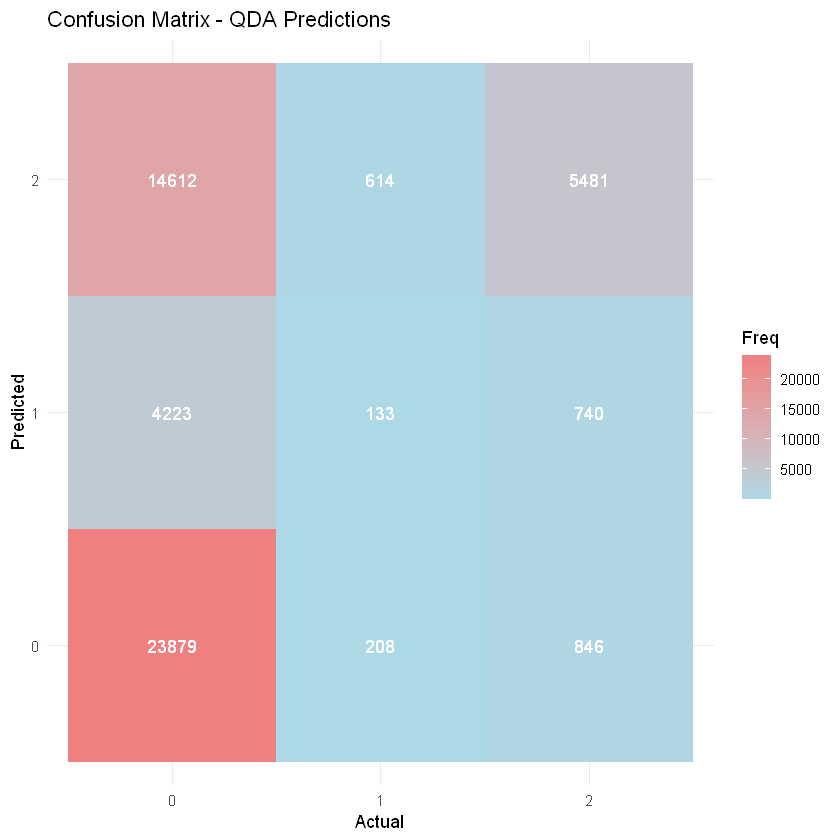

In [106]:
conf_matrix <- table(test_data$diabetes_012, undersampling_results$qda_predictions)
conf_matrix

eval_multi_class(conf_matrix)

# Plot confusion matrix using the function
plot_confusion_matrix(conf_matrix, "QDA")

### Thử trên Data SMOTE Sampling

In [12]:
smote_data <- read.csv("../data/smote_augmented_data_80_percent.csv")
smote_data <- smote_data |> mutate(across(everything(), as.factor))

glimpse(smote_data)
table(smote_data$diabetes_012)

Rows: 444,571
Columns: 21
$ diabetes_012           <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,~
$ high_bp                <fct> 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,~
$ high_chol              <fct> 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,~
$ chol_check             <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,~
$ smoker                 <fct> 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,~
$ stroke                 <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,~
$ heart_diseaseor_attack <fct> 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,~
$ phys_activity          <fct> 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,~
$ fruits                 <fct> 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,~
$ veggies                <fct> 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,~
$ hvy_alcohol_consump    <fct> 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,~
$ any_healthcare         <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,~
$ no_docbc_cos


     0      1      2 
170989 136791 136791 

### Train với thông số cơ bản

In [91]:
smote_results <- evaluate_models(smote_data, test_data)

             Metric       LDA.1       LDA.2       LDA.3       LDA.4       LDA.5
accuracy   Accuracy  0.54230445  0.54412129  0.54238928  0.54545966  0.53967879
precision Precision  0.52349132  0.52509562  0.52341146  0.52681658  0.52122596
recall       Recall  0.52868264  0.53020794  0.52892867  0.53237522  0.52687949
f1               F1  0.52330045  0.52507690  0.52361933  0.52689514  0.52138996
kappa         Kappa -0.05882353 -0.05882353 -0.05882353 -0.05882353 -0.05882353
                QDA.1       QDA.2       QDA.3       QDA.4       QDA.5
accuracy   0.54161840  0.53543874  0.53592235  0.53767686  0.53460647
precision  0.57659654  0.57256921  0.57019217  0.57311929  0.57158529
recall     0.53544489  0.52994456  0.53044196  0.53243052  0.52904085
f1         0.49947951  0.49315392  0.49260916  0.49495631  0.49172466
kappa     -0.05882353 -0.05882353 -0.05882353 -0.05882353 -0.05882353


   
        0     1     2
  0 29992  6365  6357
  1   332   282   341
  2  1506  1810  3751

$Precision
         0          1          2 
0.94225573 0.03334516 0.35898172 

$Recall
        0         1         2 
0.7021585 0.2952880 0.5307769 

$Accuracy
[1] 0.6706284

$Kappa
[1] 0.2514368

$Macro_F1
[1] 0.1076314

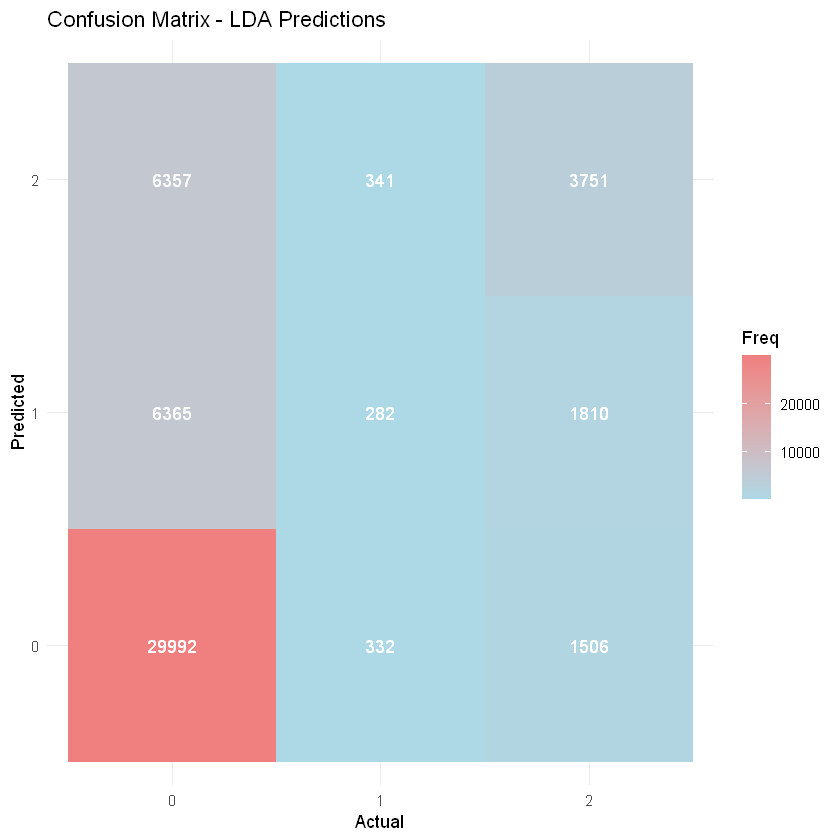

In [92]:
conf_matrix <- table(test_data$diabetes_012, smote_results$lda_predictions)
conf_matrix

eval_multi_class(conf_matrix)

# Plot confusion matrix using the function
plot_confusion_matrix(conf_matrix, "LDA")

   
        0     1     2
  0 25790  2274 14650
  1   252    81   622
  2  1078   392  5597

$Precision
         0          1          2 
0.95095870 0.02948671 0.26819685 

$Recall
         0          1          2 
0.60378330 0.08481675 0.79199094 

$Accuracy
[1] 0.6202302

$Kappa
[1] 0.2275953

$Macro_F1
[1] 0.09276237

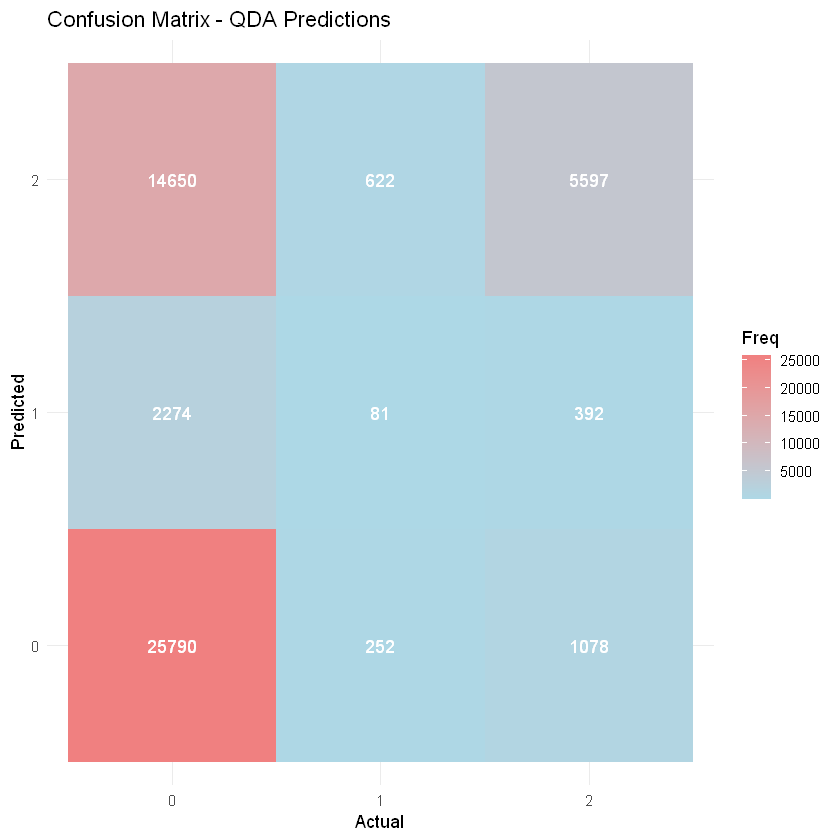

In [94]:
conf_matrix <- table(test_data$diabetes_012, smote_results$qda_predictions)
conf_matrix

eval_multi_class(conf_matrix)

# Plot confusion matrix using the function
plot_confusion_matrix(conf_matrix, "QDA")

## Modeling With Binary 0 & {1, 2}

In [17]:
convert_to_binary <- function(data) {
    data |> mutate(diabetes_012 = ifelse(diabetes_012 %in% c(1, 2), 1, ifelse(diabetes_012 == 0, 0, diabetes_012)))
}


binary_train_data <- convert_to_binary(train_data)
binary_oversampling_data <- convert_to_binary(oversampling_data)
binary_undersampling_data <- convert_to_binary(undersampling_data)
binary_smote_data <- convert_to_binary(smote_data)
binary_test_data <- convert_to_binary(test_data)

In [22]:
table(binary_train_data$diabetes_012)
table(binary_test_data$diabetes_012)


     0      1 
170989  31955 


    0     1 
42714  8022 

### Train Data

In [23]:
binary_results <- evaluate_models(binary_train_data, binary_test_data)

             Metric      LDA.1      LDA.2      LDA.3      LDA.4      LDA.5
accuracy   Accuracy  0.8472739  0.8490231  0.8452783  0.8480376  0.8462107
precision Precision  0.6993663  0.7058365  0.6973235  0.7074478  0.6993040
recall       Recall  0.6080822  0.6090292  0.6057129  0.6107282  0.6096191
f1               F1  0.6305286  0.6323068  0.6276369  0.6341451  0.6320218
kappa         Kappa -0.1111111 -0.1111111 -0.1111111 -0.1111111 -0.1111111
               QDA.1      QDA.2      QDA.3      QDA.4      QDA.5
accuracy   0.6875755  0.6866146  0.6866392  0.6946710  0.6912388
precision  0.6240902  0.6207991  0.6231624  0.6277634  0.6251736
recall     0.7256909  0.7188930  0.7219810  0.7288505  0.7252922
f1         0.6112594  0.6084725  0.6106016  0.6179801  0.6142344
kappa     -0.1111111 -0.1111111 -0.1111111 -0.1111111 -0.1111111


Warning message in cc * sc:
"NAs produced by integer overflow"


Cho LDA

   
        0     1
  0 40992  1722
  1  5981  2041

Warning message in cc * sc:
"NAs produced by integer overflow"


$Precision
        0         1 
0.8726715 0.5423864 

$Recall
        0         1 
0.9596853 0.2544253 

$Accuracy
[1] 0.8481749

$Kappa
[1] NA

$Macro_F1
[1] 0.2806639

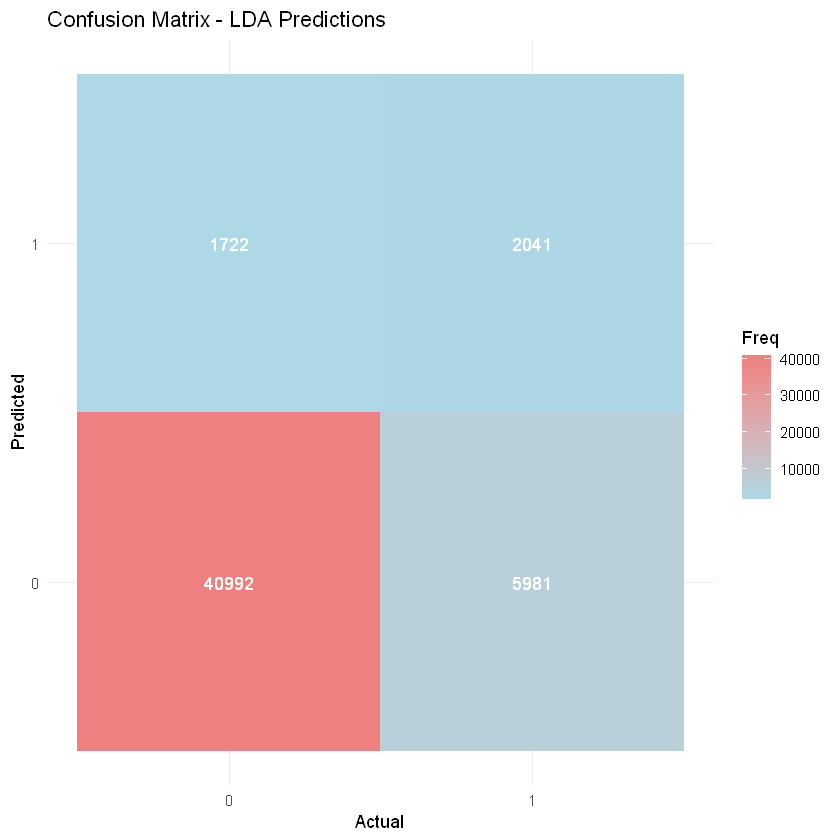

In [28]:
conf_matrix <- table(binary_test_data$diabetes_012, binary_results$lda_predictions)
conf_matrix

eval_multi_class(conf_matrix)

# Plot confusion matrix using the function
plot_confusion_matrix(conf_matrix, "LDA")

Cho QDA

   
        0     1
  0 28734 13980
  1  1840  6182

$Precision
        0         1 
0.9398181 0.3066164 

$Recall
        0         1 
0.6727068 0.7706308 

$Accuracy
[1] 0.6881898

$Kappa
[1] 0.2745871

$Macro_F1
[1] 0.3008149

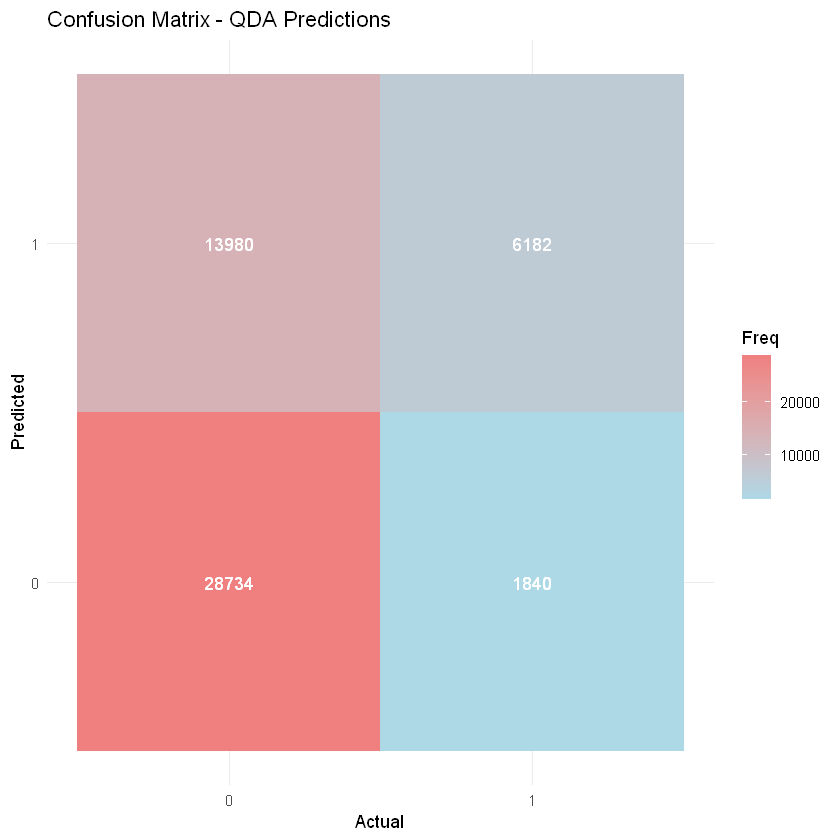

In [30]:
conf_matrix <- table(binary_test_data$diabetes_012, binary_results$qda_predictions)
conf_matrix

eval_multi_class(conf_matrix)

# Plot confusion matrix using the function
plot_confusion_matrix(conf_matrix, "QDA")

### Oversampling Data

In [31]:
oversampling_results_binary <- evaluate_models(binary_oversampling_data, binary_test_data)

             Metric      LDA.1      LDA.2      LDA.3      LDA.4      LDA.5
accuracy   Accuracy  0.7430917  0.7437974  0.7428414  0.7443485  0.7453382
precision Precision  0.7342109  0.7358072  0.7337612  0.7343969  0.7353662
recall       Recall  0.7092975  0.7103673  0.7088006  0.7106738  0.7100983
f1               F1  0.7157816  0.7168622  0.7153038  0.7171473  0.7168903
kappa         Kappa -0.1111111 -0.1111111 -0.1111111 -0.1111111 -0.1111111
               QDA.1      QDA.2      QDA.3      QDA.4      QDA.5
accuracy   0.7256481  0.7265672  0.7267022  0.7277707  0.7273545
precision  0.7102217  0.7119921  0.7114207  0.7120222  0.7109124
recall     0.7023952  0.7019216  0.7017037  0.7028072  0.7015958
f1         0.7053766  0.7054830  0.7052098  0.7062139  0.7050515
kappa     -0.1111111 -0.1111111 -0.1111111 -0.1111111 -0.1111111


Cho LDA

   
        0     1
  0 24082 18632
  1   887  7135

$Precision
        0         1 
0.9644760 0.2769046 

$Recall
        0         1 
0.5637964 0.8894291 

$Accuracy
[1] 0.615283

$Kappa
[1] 0.2387531

$Macro_F1
[1] 0.30194

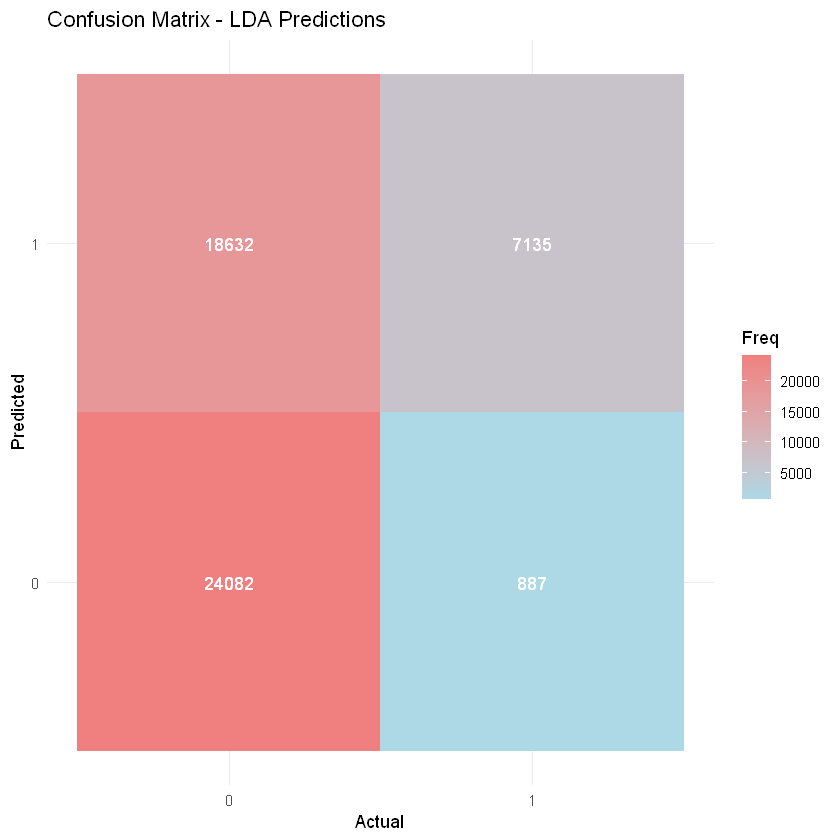

In [32]:
conf_matrix <- table(binary_test_data$diabetes_012, oversampling_results_binary$lda_predictions)
conf_matrix

eval_multi_class(conf_matrix)

# Plot confusion matrix using the function
plot_confusion_matrix(conf_matrix, "LDA")

Cho QDA

   
        0     1
  0 25403 17311
  1  1281  6741

$Precision
        0         1 
0.9519937 0.2802678 

$Recall
        0         1 
0.5947230 0.8403141 

$Accuracy
[1] 0.6335541

$Kappa
[1] 0.2401551

$Macro_F1
[1] 0.2930896

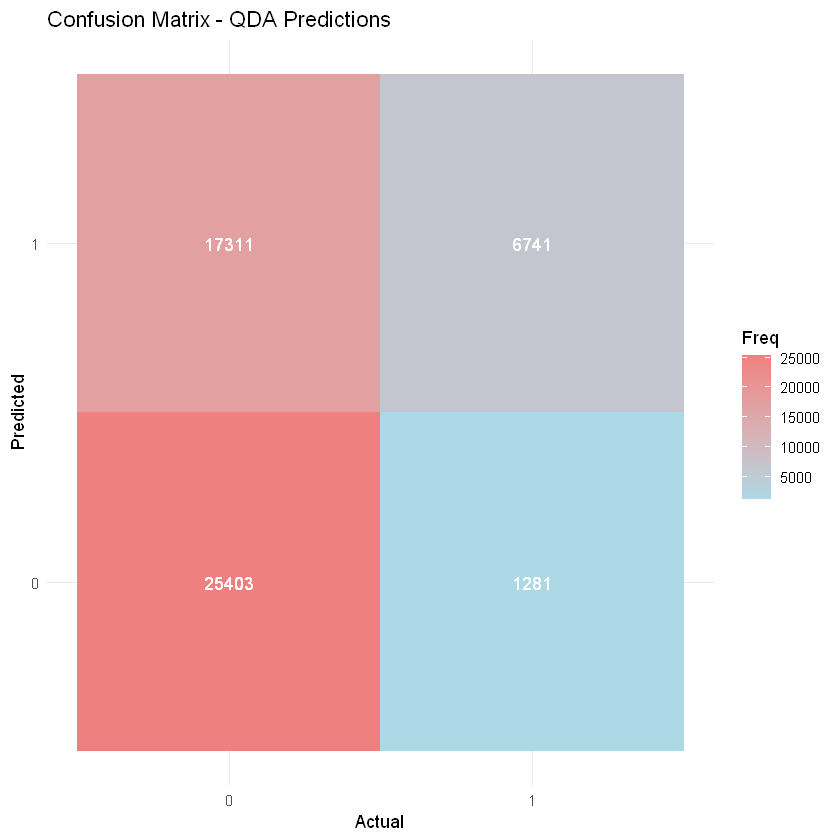

In [33]:
conf_matrix <- table(binary_test_data$diabetes_012, oversampling_results_binary$qda_predictions)
conf_matrix

eval_multi_class(conf_matrix)

# Plot confusion matrix using the function
plot_confusion_matrix(conf_matrix, "QDA")

### Undersampling Data

In [34]:
undersampling_results_binary <- evaluate_models(binary_undersampling_data, binary_test_data)

             Metric      LDA.1      LDA.2      LDA.3      LDA.4      LDA.5
accuracy   Accuracy  0.7543064  0.7592928  0.7683590  0.7714286  0.7687075
precision Precision  0.7368919  0.7318562  0.7474433  0.7487436  0.7541980
recall       Recall  0.6884219  0.6917470  0.7129616  0.7074129  0.6992949
f1               F1  0.6997988  0.7032028  0.7236868  0.7197328  0.7127803
kappa         Kappa -0.1111111 -0.1111111 -0.1111111 -0.1111111 -0.1111111
               QDA.1      QDA.2      QDA.3      QDA.4      QDA.5
accuracy   0.7252947  0.7393472  0.7330009  0.7342404  0.7473923
precision  0.6924671  0.7027443  0.7004363  0.6979768  0.7157333
recall     0.6805383  0.6980625  0.6938325  0.6956857  0.6985518
f1         0.6851164  0.7002170  0.6967196  0.6967827  0.7049851
kappa     -0.1111111 -0.1111111 -0.1111111 -0.1111111 -0.1111111


Cho LDA

   
        0     1
  0 21535 21179
  1   651  7371

$Precision
        0         1 
0.9706572 0.2581786 

$Recall
        0         1 
0.5041673 0.9188482 

$Accuracy
[1] 0.5697335

$Kappa
[1] 0.2074433

$Macro_F1
[1] 0.2882689

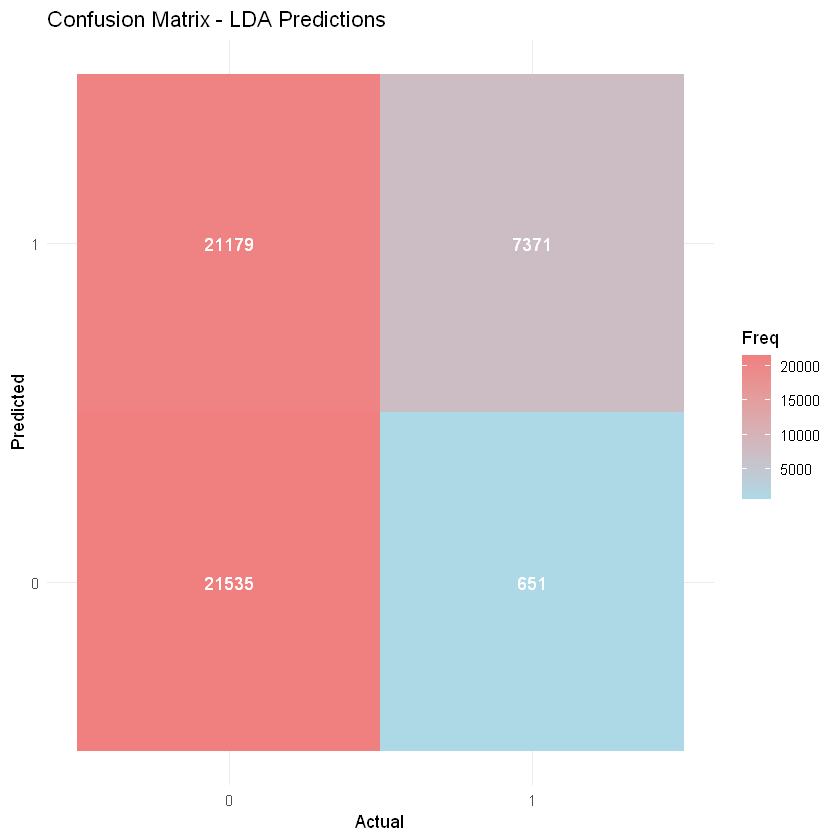

In [35]:
conf_matrix <- table(binary_test_data$diabetes_012, undersampling_results_binary$lda_predictions)
conf_matrix

eval_multi_class(conf_matrix)

# Plot confusion matrix using the function
plot_confusion_matrix(conf_matrix, "LDA")

Cho QDA

   
        0     1
  0 24384 18330
  1  1145  6877

$Precision
       0        1 
0.955149 0.272821 

$Recall
        0         1 
0.5708667 0.8572675 

$Accuracy
[1] 0.6161503

$Kappa
[1] 0.2289545

$Macro_F1
[1] 0.2894733

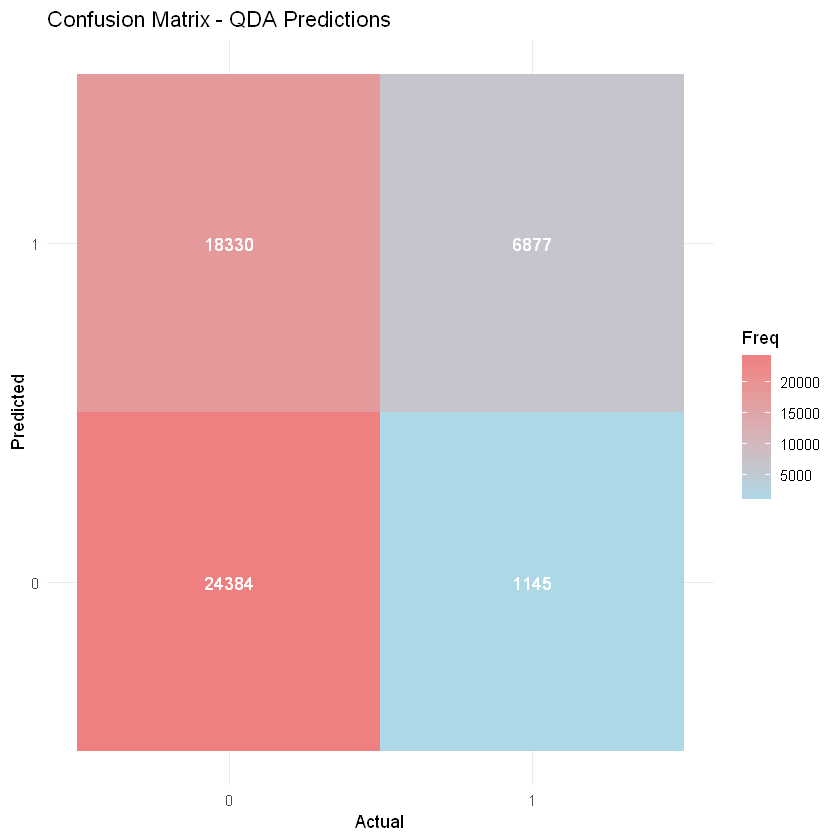

In [36]:
conf_matrix <- table(binary_test_data$diabetes_012, undersampling_results_binary$qda_predictions)
conf_matrix

eval_multi_class(conf_matrix)

# Plot confusion matrix using the function
plot_confusion_matrix(conf_matrix, "QDA")

### SMOTE Data

In [37]:
smote_results_binary <- evaluate_models(binary_undersampling_data, binary_test_data)

             Metric      LDA.1      LDA.2      LDA.3      LDA.4      LDA.5
accuracy   Accuracy  0.7543064  0.7592928  0.7683590  0.7714286  0.7687075
precision Precision  0.7368919  0.7318562  0.7474433  0.7487436  0.7541980
recall       Recall  0.6884219  0.6917470  0.7129616  0.7074129  0.6992949
f1               F1  0.6997988  0.7032028  0.7236868  0.7197328  0.7127803
kappa         Kappa -0.1111111 -0.1111111 -0.1111111 -0.1111111 -0.1111111
               QDA.1      QDA.2      QDA.3      QDA.4      QDA.5
accuracy   0.7252947  0.7393472  0.7330009  0.7342404  0.7473923
precision  0.6924671  0.7027443  0.7004363  0.6979768  0.7157333
recall     0.6805383  0.6980625  0.6938325  0.6956857  0.6985518
f1         0.6851164  0.7002170  0.6967196  0.6967827  0.7049851
kappa     -0.1111111 -0.1111111 -0.1111111 -0.1111111 -0.1111111


Cho LDA

   
        0     1
  0 21535 21179
  1   651  7371

$Precision
        0         1 
0.9706572 0.2581786 

$Recall
        0         1 
0.5041673 0.9188482 

$Accuracy
[1] 0.5697335

$Kappa
[1] 0.2074433

$Macro_F1
[1] 0.2882689

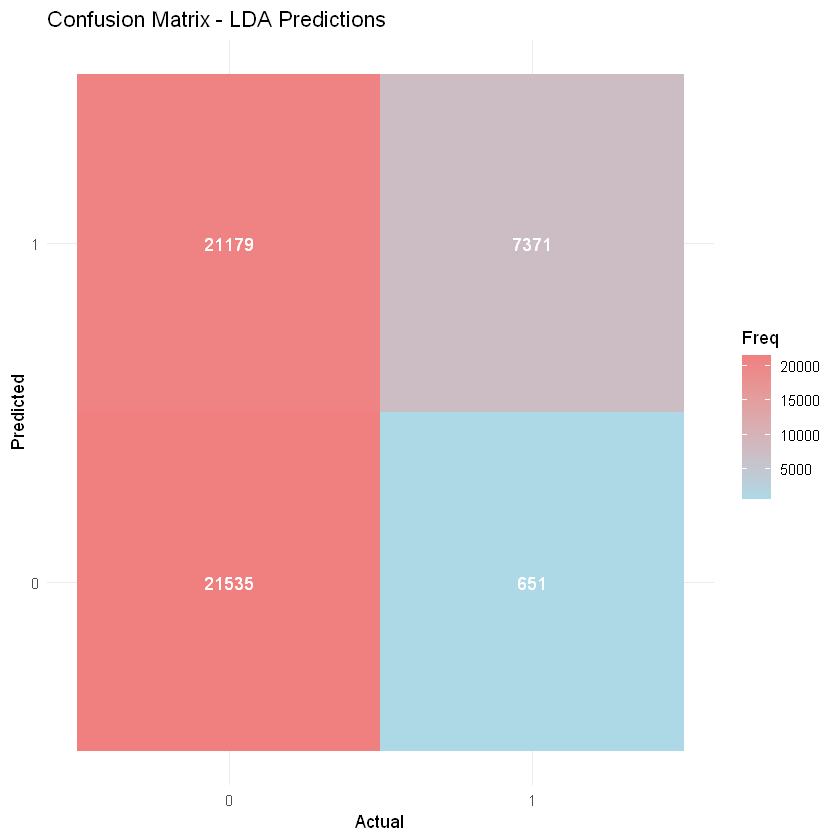

In [38]:
conf_matrix <- table(binary_test_data$diabetes_012, smote_results_binary$lda_predictions)
conf_matrix

eval_multi_class(conf_matrix)

# Plot confusion matrix using the function
plot_confusion_matrix(conf_matrix, "LDA")

Cho QDA

   
        0     1
  0 24384 18330
  1  1145  6877

$Precision
       0        1 
0.955149 0.272821 

$Recall
        0         1 
0.5708667 0.8572675 

$Accuracy
[1] 0.6161503

$Kappa
[1] 0.2289545

$Macro_F1
[1] 0.2894733

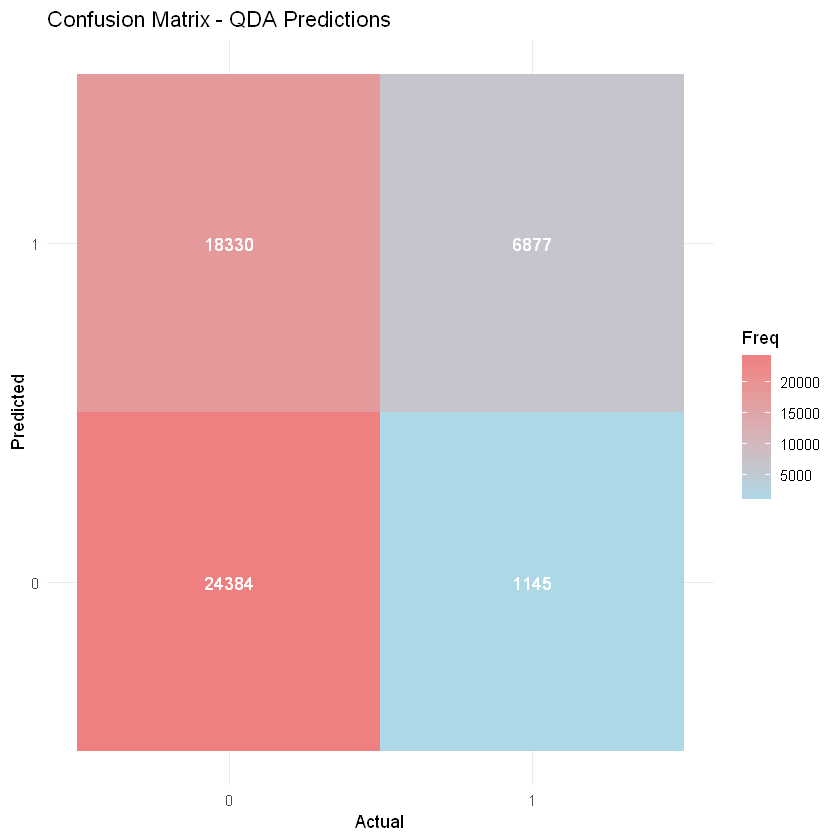

In [39]:
conf_matrix <- table(binary_test_data$diabetes_012, smote_results_binary$qda_predictions)
conf_matrix

eval_multi_class(conf_matrix)

# Plot confusion matrix using the function
plot_confusion_matrix(conf_matrix, "QDA")